In [1]:
import pandas as pd
import numpy as np
import valuation_dcf as vd

# The basic building blocks

The basic building blocks are the pieces that we can use to generate cash-flow tables. Here is their hierarchy diagram, with black arrows denoting generation of the target: 

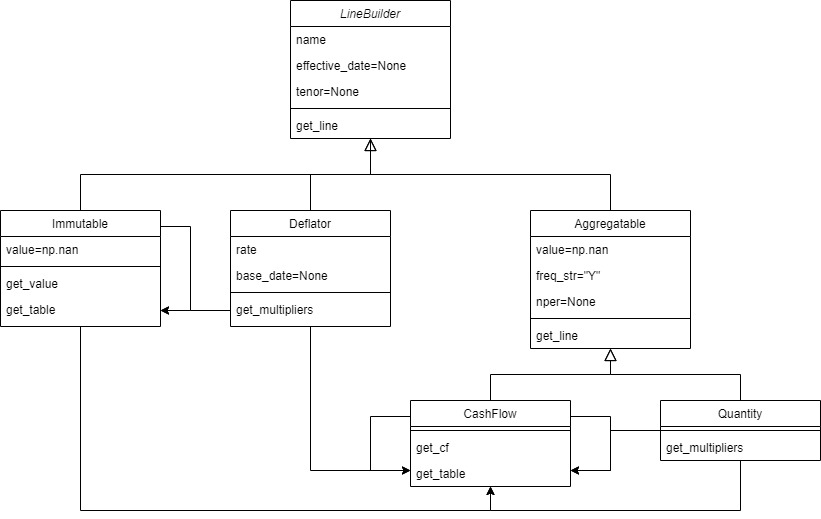

This should be understandable after reading the explanations below.

## CashFlow

The most basic cash-flow only has a name, a value and frequency:

In [2]:
cf = vd.CashFlow(name="A", freq_str="Y")

We can not set a value, in which case we just get empty lines:

In [3]:
cf.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,NaN,NaN,NaN,NaN,NaN


But we can only see the cash-flow class at work with a value:

In [4]:
cf = vd.CashFlow(name="A", value=100, freq_str="Y")

Its cash-flow and table will both return a single line named as the object itself, and filled according to its value and frequency. Note how we ask for the line by setting the start date of the first period, the number of periods, and the corresponding length of the period (in this case yearly like the cash-flow itself).

In [5]:
cf.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,100.0,100.0,100.0,100.0,100.0


The table of such an elemental cash-flow collapses simply to its line.

In [6]:
cf.get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,100.0,100.0,100.0,100.0,100.0


In the above table, 2023 counts as "period 1"; if we want to include a "period 0" (e.g., for and investment phase), we can request so explicitly:

In [7]:
cf.get_cf(start_date="20220101", nper=5, freq="Y", initial_period=True)

,2021-12-31,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,100.0,100.0,100.0,100.0,100.0,100.0


A cash-flow is "aggregatable" in the sense that its values sum and subdivide according to the relation between its frequency and the requested accounting frequency:

In [8]:
cf.get_cf(start_date="20220101", nper=5, freq="M")

,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31
A,8.333333,8.333333,8.333333,8.333333,8.333333


In [9]:
cf.get_cf(start_date="20220101", nper=5, freq="Q")

,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31
A,25.0,25.0,25.0,25.0,25.0


In [10]:
cf.get_cf(start_date="20220101", nper=5, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30
A,50.0,50.0,50.0,50.0,50.0


(No other frequencies are supported so far.)

Two additional specifications are an "effective date" for when the cash flow starts, and a number of periods for which it lasts.

In [11]:
cf = vd.CashFlow(name="A", value=100, freq_str="Y", effective_date="20240101", nper=2)

When we now request the cash-flow line, only the relevant periods are non-zero

In [12]:
cf.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,100.0,0.0


even when subdividing:

In [13]:
cf.get_cf(start_date="20220101", nper=10, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31
A,0.0,0.0,0.0,0.0,50.0,50.0,50.0,50.0,0.0,0.0


This is true even if the each accounting period is not fully taken by cash-flow periods, at the start or the end: in the next example, there are two paying semesters only in 2025, with a single semester in 2024 and 2026.

In [14]:
cf = vd.CashFlow(name="A", value=100, freq_str="2Q", effective_date="20240701", nper=4)

In [15]:
cf.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0


(It deals more generally with non-alignments, but one should not have them.)

Finally, we can take the negative of a cash-flow, sum and substract them, as well as multiply by constants:

In [16]:
(-cf).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
(A),-0.0,-0.0,-100.0,-200.0,-100.0


In [17]:
(-cf).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
(A),-0.0,-0.0,-100.0,-200.0,-100.0


In [18]:
cf2 = vd.CashFlow(name="B", value=50, freq_str="2Q", effective_date="20240701", nper=4)

(Note how the difference in effective dates and pay frequencies.)

In [19]:
(cf+cf2).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A+B,0.0,0.0,150.0,300.0,150.0


We can generate our first example of a non-trivial table:

In [20]:
(cf+cf2).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0
B,0.0,0.0,50.0,100.0,50.0
A+B,0.0,0.0,150.0,300.0,150.0


In [21]:
(cf-cf2).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A-B,0.0,0.0,50.0,100.0,50.0


In [22]:
(cf-cf2).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0
(B),-0.0,-0.0,-50.0,-100.0,-50.0
A-B,0.0,0.0,50.0,100.0,50.0


In [23]:
(2*cf).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity x A,0.0,0.0,200.0,800.0,200.0


In [24]:
(2*cf).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0
Quantity,0.0,0.0,2.0,4.0,2.0
Quantity x A,0.0,0.0,200.0,800.0,200.0


(If we want to personalize the line name for the multiplier amount, we need to use the Quantity class below, instead of simply multiplying by a constant.)

## Immutable

The difference between the Immutable and the CashFlow classes is that the Immutable one is not changed by the accounting frequency. It is used for things like prices, which can change in time, but are not changed just because we do quarterly accounting instead of yearly.

In [25]:
price = vd.Immutable(name="Electricity", value=100)

The method to call for the line is different, so that the immutable objects are not confused with cash-flow ones.

In [26]:
price.get_value(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,100,100,100,100,100


In [27]:
price.get_value(start_date="20220101", nper=10, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31
Electricity,100,100,100,100,100,100,100,100,100,100


They can also have an "effective date", from which the price is non-zero, and a "tenor", for the length of which it is non-zero:

In [28]:
price = vd.Immutable(name="Electricity", value=100, effective_date="20230101", tenor=2)

In [29]:
price.get_value(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0,100,100,0,0


Using which we can generate an example of an immutable, but time-changing price:

In [30]:
price2 = vd.Immutable(name="Electricity", value=120, effective_date="20250101", tenor=1)
all_prices = price + price2
all_prices.name = "Electricity"

In [31]:
all_prices.get_value(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0,100,100,120,0


In [32]:
all_prices.get_value(start_date="20220101", nper=10, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31
Electricity,0,0,100,100,100,100,120,120,0,0


In [33]:
all_prices.get_table(start_date="20220101", nper=10, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31
Electricity,0,0,100,100,100,100,0,0,0,0
Electricity,0,0,0,0,0,0,120,120,0,0
Electricity,0,0,100,100,100,100,120,120,0,0


There is an implementation of multiplication by constant, which interprets the constant as a "quantity purchased" and returns a cash-flow (notice how we request .get_cf, and not .get_value):

In [34]:
(2*price).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity x Electricity,0.0,200.0,200.0,0.0,0.0


In [35]:
(2*price).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0.0,100.0,100.0,0.0,0.0
Quantity,0.0,2.0,2.0,0.0,0.0
Quantity x Electricity,0.0,200.0,200.0,0.0,0.0


## Quantity

The next building block is used to generalize the "multiplication by constant" mentioned for each of the cases above. It is used to multiply be cash-flows, returning a cash-flow; and by immutables, returning a cash-flow as well.

The first example of this generalization is a quantity that is non-zero only between some dates (that may not coincide with the immutable or cash flow dates):

In [36]:
quantity = vd.Quantity(name="Quantity", value=2, effective_date="20230101", tenor=2, freq_str="Y")

In [37]:
quantity.get_multipliers(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity,0.0,2.0,2.0,0.0,0.0


Quantities are aggregatable, like cash-flows (e.g., it's a given quantity bought each period, or an amount received each period):

In [38]:
quantity.get_multipliers(start_date="20220101", nper=10, freq="2Q")

,2022-06-30,2022-12-31,2023-06-30,2023-12-31,2024-06-30,2024-12-31,2025-06-30,2025-12-31,2026-06-30,2026-12-31
Quantity,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Again, we can use sums to easily define a time-changing quantity and generate an example that time-varying (beyond being non-zero):

In [39]:
quantity2 = vd.Quantity(name="Quantity", value=3, effective_date="20250101", tenor=1, freq_str="Y")
total_quantity = quantity + quantity2
total_quantity.name = "Quantity"

In [40]:
total_quantity.get_multipliers(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity,0.0,2.0,2.0,3.0,0.0


And now the real purpose of the quantity class: we can multiply by a price (immutable) and get a cash-flow (again, note that we are calling get_cf):

In [41]:
(total_quantity*all_prices).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity x Electricity,0.0,200.0,200.0,360.0,0.0


In [42]:
(total_quantity*all_prices).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0,100,100,120,0
Quantity,0.0,2.0,2.0,3.0,0.0
Quantity x Electricity,0.0,200.0,200.0,360.0,0.0


Analogously, we can multiply by cash-flows:

In [43]:
(total_quantity*cf).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Quantity x A,0.0,0.0,200.0,600.0,0.0


In [44]:
(total_quantity*cf).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0
Quantity,0.0,2.0,2.0,3.0,0.0
Quantity x A,0.0,0.0,200.0,600.0,0.0


## Flator

The final piece is a de- or in- Flator, which to just that, grow or discount prices and cash-flows.

In [45]:
inflation = vd.Flator(name="Inflation", rate=0.02)

In [46]:
inflation.get_multipliers(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation,1.02,1.0404,1.061266,1.082491,1.104141


It assumes period 0 is the base date by default...

In [47]:
inflation.get_multipliers(start_date="20220101", nper=5, freq="Y", initial_period=True)

,2021-12-31,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation,1.0,1.02,1.0404,1.061266,1.082491,1.104141


... but we can still pass it a base date (notice how the value for period 0 now is different from 1).

In [48]:
inflation = vd.Flator(name="Inflation", rate=0.02, base_date="20201231")

In [49]:
inflation.get_multipliers(start_date="20220101", nper=5, freq="Y", initial_period=True)

,2021-12-31,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation,1.02,1.0404,1.061208,1.082491,1.104141,1.126224


To grow or discount prices and cash-flows, we just multiply like for constants and quantities:

**Immutables**

In [50]:
(inflation*all_prices).get_value(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation-flated Electricity,0.0,106.1208,108.249089,132.496885,0.0


Again, we get non-trivial tables:

In [51]:
(inflation*all_prices).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0,100,100,120,0
Inflation,0.0,1.061208,1.082491,1.104141,0.0
Inflation-flated Electricity,0.0,106.1208,108.249089,132.496885,0.0


**Cash-flows**

In [52]:
(inflation*cf).get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation x A,0.0,0.0,108.249089,220.828141,112.622352


Again, we get non-trivial tables:

In [53]:
(inflation*cf).get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0000,0.000000,100.000000,200.000000,100.000000
Inflation,1.0404,1.061208,1.082491,1.104141,1.126224
Inflation x A,0.0000,0.000000,108.249089,220.828141,112.622352


## Discounting and net present values

We have just seen how to discount using Flators. We can do it using a method of CashFlow:

In [54]:
cf.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
A,0.0,0.0,100.0,200.0,100.0


In [55]:
cf.get_dcf(discount_rate=0.02,start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Discounted A,0.0,0.0,94.113991,184.463422,90.387077


In [56]:
deflator = vd.Flator(name="Discount", rate=-.02)
cf.get_dcf(deflator=deflator,start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Discounted A,0.0,0.0,94.113991,184.463422,90.387077


and we can also ask for it net present value using that discounting:

In [57]:
cf.get_npv(deflator=deflator,start_date="20220101", nper=5, freq="Y")

,Discounted A
2022-01-01,368.964489


## A more elaborate example - and longer tables

We can compound on the previous examples, and easily build, for example, a table of sales of a product with a price that grows with inflation. First define the price grown as inflation as a product...

In [58]:
grown_price = price*inflation

... then multiply it by quantities sold, to get a cash-flow:

In [59]:
sales = quantity*grown_price
sales.name = "Sales"

In [60]:
sales.get_cf(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Sales,0.0,212.2416,216.498178,0.0,0.0


In [61]:
sales.get_table(start_date="20220101", nper=5, freq="Y")

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation-flated Electricity,0.0,106.1208,108.249089,0.0,0.0
Quantity,0.0,2.0000,2.000000,0.0,0.0
Sales,0.0,212.2416,216.498178,0.0,0.0


This is also our first example whe we can see tables with different breakdown levels:

In [62]:
sales.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=0)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Sales,0.0,212.2416,216.498178,0.0,0.0


In [63]:
sales.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=1)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Inflation-flated Electricity,0.0,106.1208,108.249089,0.0,0.0
Quantity,0.0,2.0000,2.000000,0.0,0.0
Sales,0.0,212.2416,216.498178,0.0,0.0


In [64]:
sales.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=2)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0.0,100.000000,100.000000,0.0,0.0
Inflation,0.0,1.061208,1.082491,0.0,0.0
Inflation-flated Electricity,0.0,106.120800,108.249089,0.0,0.0
Quantity,0.0,2.000000,2.000000,0.0,0.0
Sales,0.0,212.241600,216.498178,0.0,0.0


Essentially, each table is a collection of subtables, and the breakdown level is inductive: breakdown level 0 is just the cash-flow line; breakdown level 1 is the table with each subtable at breakdown level 0, i.e., a table of lines; breakdown level 2 is a table with each subtable in breakdown 1, or a table of tables; etc...

This example took us to level 2, but 3 already collapses down to 2, because there is not further breakdown granularity avialable (we have gone all the way down):

In [65]:
sales.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=3)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0.0,100.000000,100.000000,0.0,0.0
Inflation,0.0,1.061208,1.082491,0.0,0.0
Inflation-flated Electricity,0.0,106.120800,108.249089,0.0,0.0
Quantity,0.0,2.000000,2.000000,0.0,0.0
Sales,0.0,212.241600,216.498178,0.0,0.0


A good way of getting deeper levels is to use the table classes (EBITDA, Enterprise, Equity), but you can also just do it by hand, as an exercise in playing with the building blocks

There is a version of this example implemented as a subclass.

In [66]:
sales1 = vd.SalesCashFlow(price=100, product_name="Electricity", quantities=2, rate=0.02, rate_name="Inflation", base_date="20201231")
sales1.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=2)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,100.0000,100.000000,100.000000,100.000000,100.000000
Inflation,1.0404,1.061208,1.082491,1.104141,1.126224
Electricity price,104.0400,106.120800,108.249089,110.414071,112.622352
Quantity,2.0000,2.000000,2.000000,2.000000,2.000000
Electricity sales,208.0800,212.241600,216.498178,220.828141,225.244704


The cash-flow is alway non-zero because we passed only constants. We can customize by passing an appropriate quantities (or price) object.

In [67]:
sales2 = vd.SalesCashFlow(price=100, product_name="Electricity", quantities=quantity, rate=0.02, rate_name="Inflation", base_date="20201231")
sales2.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=2)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,100.0000,100.000000,100.000000,100.000000,100.000000
Inflation,1.0404,1.061208,1.082491,1.104141,1.126224
Electricity price,104.0400,106.120800,108.249089,110.414071,112.622352
Quantity,0.0000,2.000000,2.000000,0.000000,0.000000
Electricity sales,0.0000,212.241600,216.498178,0.000000,0.000000


In [68]:
sales1 = vd.SalesCashFlow(price=price, product_name="Electricity", quantities=2, rate=0.02, rate_name="Inflation", base_date="20201231")
sales1.get_table(start_date="20220101", nper=5, freq="Y", breakdown_level=2)

,2022-12-31,2023-12-31,2024-12-31,2025-12-31,2026-12-31
Electricity,0.0,100.000000,100.000000,0.0,0.0
Inflation,0.0,1.061208,1.082491,0.0,0.0
Electricity price,0.0,106.120800,108.249089,0.0,0.0
Quantity,2.0,2.000000,2.000000,2.0,2.0
Electricity sales,0.0,212.241600,216.498178,0.0,0.0
